# Question 2 - Implementing CDF Estimatio

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2.1 Simple Histogram CDF Algorithm Implementation

In [0]:
FLOAT_EPS = 1e-8


def _get_bin_index(t, bins):
    """Compute the index of bin"""
    return (np.floor(t * bins) + FLOAT_EPS).astype(int)


def true_CDF_factory(x):
    """True CDF factory."""
    
    x = np.array(x)
    x.sort()  # Empirically, sorting tha array makes the function run faster

    def cdf(t):
        # Using SciPy function is slightly faster than np.mean(x <= t)
        return stats.percentileofscore(x, t)/100 
        
    return cdf


def true_CDF_values(x, points):
    """Fast compute of CDF of array `x` at given `points`."""

    hist_values, bins = np.histogram(x, points-FLOAT_EPS, range=(0, 1))
    normalized_hist_values = hist_values / len(x)
    cumulative_hist = np.append(np.cumsum(normalized_hist_values),
                                1.0)
    return cumulative_hist


def test_true_cdf_consistency():
    x = generate_data(10**5)
    intervals = np.arange(0, 1, 1/2**16)
    interesting_points = np.concatenate((intervals, x))
    interesting_points.sort()  # Empirically, sorting tha array makes the function run faster

    cdf = true_CDF_factory(x)
    true_vals1 = np.array([cdf(t) for t in interesting_points])
    true_vals2 = true_CDF_values(x, interesting_points)

    np.testing.assert_almost_equal(true_vals1, true_vals2,
                                   decimal=4)


def simple_histogram_CDF_factory(x, alpha, epsilon, is_alpha_log_half=True):
    """Build CDF according to the Simple Histogram algorithm."""
    
    x = np.array(x)
    
    if is_alpha_log_half:
        alpha = (1/2)**alpha

    assert (0 < alpha < 1) and (1/alpha).is_integer()
    
    bins = int(1/alpha)
    hist_values, _ = np.histogram(x, bins, range=(0,1))
    normalized_hist_values = hist_values / len(x)
    
    laplacian_noise =  np.random.laplace(loc=0,
                                         scale=2/(epsilon * len(x)),
                                         size=bins)
    noisy_hist = normalized_hist_values + laplacian_noise

    cumulative_noisy_hist = np.insert(np.cumsum(noisy_hist),
                                      0, 0)

    def cdf_hat(t):        
        bin_index = _get_bin_index(t, bins)
        up_to_part = cumulative_noisy_hist[bin_index]
        last_bin_part = (t/alpha - bin_index) * noisy_hist[bin_index]
        
        return up_to_part + last_bin_part
    
    return noisy_hist, cdf_hat
    

def generate_data(size):
    return np.clip(np.random.normal(0.7, 0.01, size), 0, 0.99)


def compute_error(cdf_approx, x, resolution, is_resolution_log_half=True):
    """Compute the maximum errors between two CDFs on datapoints and points by interval resolution."""
    
    if is_resolution_log_half:
        resolution = (1/2)**resolution

    intervals = np.arange(0, 1, resolution)

    interesting_points = np.concatenate((intervals, x))
    interesting_points.sort()  # Empirically, sorting tha array makes the function run faster

    cdf_values = true_CDF_values(x, interesting_points)
    
    try:
        # If the CDF function support vectorization
        cdf_approx_values = np.apply_along_axis(cdf_approx, 0, interesting_points)
    except ValueError:
        # Else fall back to Python loop
        cdf_approx_values = np.array([cdf_approx(t) for t in interesting_points])
    
    return np.max(np.abs(cdf_values - cdf_approx_values))


test_true_cdf_consistency()

## 2.2 Simple Histogram CDF Algorithm Testing

In [0]:
def apply_experiment(cdf_hat_factory,
                     parameter_values,
                     parameter_name,
                     n_exps=np.arange(2, 6),
                     epsilon=0.5,
                     n_trials=20):

    results = []

    for n_exp in tqdm(n_exps):
        n = 10**n_exp
        for parameter in parameter_values:
            errs = []
            
            for _ in range(n_trials):
                x = generate_data(n)
                cdfh  = cdf_hat_factory(x, parameter, epsilon)
                errs.append(compute_error(cdfh, x, parameter))

            results.append({'n': f'$10^{n_exp}$',
                            parameter_name: parameter,
                            'err': np.mean(errs)})
            
    return pd.DataFrame(results)


def plot_experiment(df, parameter_name, parameter_display,
                    is_logx=False, is_logy=False, figsize=(14, 7)):
    _, axes = plt.subplots(1, 2, figsize=figsize)
    
    sns.lineplot(x=parameter_name, y='err', hue='n', data=df, ax=axes[0])
    axes[0].set_xlabel(parameter_display)
    axes[0].set_ylabel('Error')

    if is_logx:
        axes[0].set_yscale('log') 
        axes[0].set_xscale('log', basex=2)
    
    (df.loc[df.groupby('n')['err'].idxmin()]
            .set_index('n')
            .rename({'err': 'Min Error',
                     parameter_name: parameter_display},
                    axis=1)
            .plot(ax=axes[1]))
    if is_logy:
      axes[1].set_yscale('log', basey=2)
    
    return axes

100%|██████████| 4/4 [00:13<00:00,  3.37s/it]


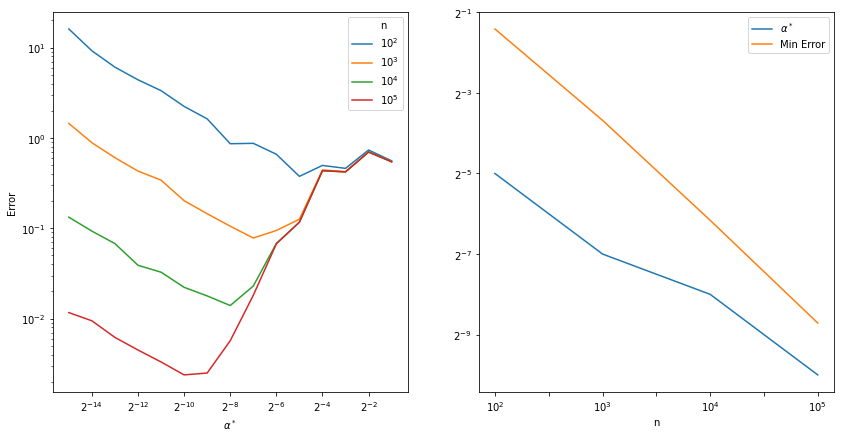

In [18]:
simple_hist_df = apply_experiment(lambda *args: simple_histogram_CDF_factory(*args)[1],
                                  range(1, 16),
                                  'alpha')
simple_hist_df['alpha'] = (1/2)**simple_hist_df['alpha']

plot_experiment(simple_hist_df, 'alpha', '$\\alpha^*$', is_logx=True, is_logy=True);

### Discussion

## 2.3 Tree Histogram CDF Algorithm Implementation

### 2.3.a
The simple histogram CDF algorithm (SH) is $\epsilon$-DP. The tree histogram CDF algorithm (TH) can be seen as a composition of $\ell$ times the SH algorithms with a privacy budget of $\epsilon\ell$. In composition, the privacy budget parameter is additive; therefore the TH algorithm is $\epsilon$-DP.

### 2.3.b
The interval $[0,1)$ can be decomposited into a binary tree with $\ell$ depth (or levels), in which every node split the interval into half. In each node we have Y the gives the sum of PMF in this itnerval. For example, with $\ell = 3$ we get:
```
[0,1) 
-> [0, 1/2) - Y_{1,1}
    -> [0, 1/4) - Y_{2,1}
        -> [0, 1/8) - Y_{3,1}
        -> [1/8, 2/8) - Y_{3,2}
    -> [1/4, 2/4) - Y_{2, 2}
        -> [2/8, 3/8) - Y_{3,3}
        -> [3/8, 4/8) - Y_{3,4}
-> [1/2, 1) - Y_{1,2}
   ...
```

Let $t \in [0,1)$ be the value of which we would like to compute $CDF(t)$. We are going to represent $CDF(t)$ as the sum of $\ell$-times $Y$, where each exactly one $Y$ is taken from each level ($k$ in the algorithm description). We will show the first step, and the following ones apply similarly:

- We start at [0,1). Its middle point is m=1/2.
- If $t \geq m$, then we can take $Y1,1$ ($=CDF(1/2)$) to our sum (that initialized with zero). Then we go to the RIGHT interval $[1/2, 1)$ and continue from there.
- If $t < m$, then we don't add any Y in this step, because only at a lower level we will have an interval that all of its elements are smaller than $t$.
- When we reach the leaf interval, which is the smallest interval in the tree that contains $t$, we use the "uniform approximation" term (second) from the SH algorithm.


### 2.3.c

In [81]:
def tree_histogram_CDF_factory(x, n_levels, epsilon):

    adjusted_epsilon = epsilon / n_levels
    simple_hist_tree = OrderedDict()

    for level in range(1, n_levels+1):
        noisy_hist, _ = simple_histogram_CDF_factory(x, level, adjusted_epsilon)
        simple_hist_tree[level] = (2**-level, noisy_hist)

    def cdf_hat(t):

        acc_prob = 0
        
        # In this implementation we don't use the middle point explicitly,
        # but keep track of the right endpoint of the interval 
        right_endpoint = 0
        
        for level, (alpha, hist) in simple_hist_tree.items():
            if t >= right_endpoint + alpha:
                right_endpoint += alpha
                level_bin_index = _get_bin_index(t, len(hist)) - 1
                acc_prob += hist[level_bin_index]

        # "Uniform approximaton" for the leaf interval, as in the SH algorithm
        last_bin_index = _get_bin_index(t, len(hist))
        last_level_part = (t/alpha - last_bin_index) * hist[last_bin_index]
        acc_prob += last_level_part
        
        return acc_prob
    
    return cdf_hat

ERROR! Session/line number was not unique in database. History logging moved to new session 65


## 2.4 Tree Histogram CDF Algorithm Testing

100%|██████████| 3/3 [03:41<00:00, 73.99s/it]


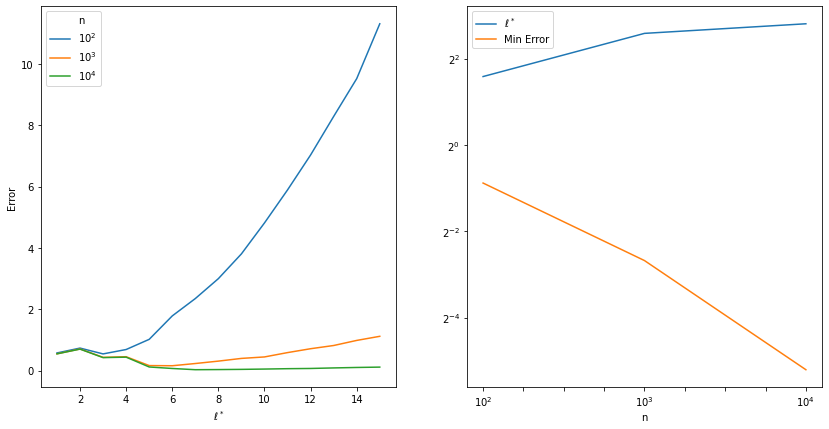

In [23]:
tree_hist_df = apply_experiment(tree_histogram_CDF_factory,
                                range(1, 16),
                                'n_levels')

plot_experiment(tree_hist_df, 'n_levels', '$\\ell^*$');

### Discussion